In [ ]:
!pip install scikit-plot


In [ ]:
!pip install scipy==1.9.3 --quiet
import os
os.kill(os.getpid(), 9)  # This restarts the Colab runtime

In [1]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#Connect To Google Drive
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv( "/content/drive/MyDrive/ml/fer2013.csv")
data.shape


Mounted at /content/drive


(35887, 3)

In [3]:
# Define the class labels (emotion categories)
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

# Create a bar chart using Plotly Express
fig = px.bar(
    x = CLASS_LABELS,  # X-axis values: emotion labels
    y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])],  # Y-axis: count of each unique emotion in the dataset
    color = np.unique(data['emotion']),  # Color bars by emotion (same order as np.unique output)
    color_continuous_scale = "Purples"  # Use the Emerald color scale (note: this is meant for continuous data)
)

# Set the label for the X-axis
fig.update_xaxes(title="Emotions")

# Set the label for the Y-axis
fig.update_yaxes(title = "Number of Images")

# Update chart layout: add title and center it at the top
fig.update_layout(
    showlegend = True,  # Show legend (optional; may be redundant in a bar chart with labeled bars)
    title = {
        'text': 'Train Data Distribution ',  # Title of the chart
        'y': 0.95,       # Vertical position of title
        'x': 0.5,        # Horizontal center
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Display the figure
fig.show()


In [4]:
# Shuffle the dataset randomly (frac=1 means 100% of the data is returned in shuffled order)
data = data.sample(frac=1)
labels = to_categorical(data[['emotion']], num_classes=7)

train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
pixels = train_pixels.reshape((35887, 48, 48, 1))

# Split into training and test datasets (10% for testing, no shuffling again)
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)

# Further split training set to get a validation set (10% of train for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

# Print the shapes to confirm the splits
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


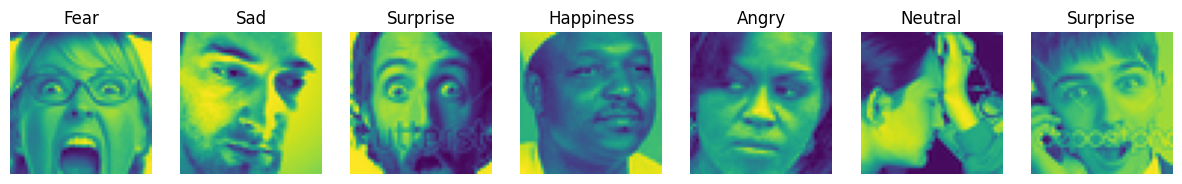

In [5]:
# Set the overall figure size
plt.figure(figsize=(15, 23))

# Dictionary to map label indices to emotion names
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Loop through the first 7 training images
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1

# Show all the subplots
plt.show()



In [6]:
# This helps improve model generalization by creating varied versions of the training and validation images
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             zoom_range=0.2)

valgen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            zoom_range=0.2)

# Prepare the generators with training and validation data
datagen.fit(X_train)
valgen.fit(X_val)

# Create batches of augmented image data for model training and validation
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = valgen.flow(X_val, y_val, batch_size=64)


In [9]:
def build_cnn_model():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Conv Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third Conv Block with regularization
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(7, activation='softmax'))  # 7 classes for emotion classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model = build_cnn_model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,244,935 (20.01 MB)

 Trainable params: 5,242,503 (20.00 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [10]:
# - ModelCheckpoint saves the model with the highest validation accuracy
checkpointer = [EarlyStopping(monitor='val_accuracy', verbose=1,
                              restore_best_weights=True, mode="max", patience=5),
                ModelCheckpoint('best_model.h5', monitor="val_accuracy", verbose=1,
                                save_best_only=True, mode="max")]

In [11]:
#Train the CNN model using the training data generator
history = model.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/20
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2070 - loss: 3.7973
Epoch 1: val_accuracy improved from -inf to 0.28266, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.2071 - loss: 3.7941 - val_accuracy: 0.2827 - val_loss: 2.0150
Epoch 2/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3019 - loss: 1.9678
Epoch 2: val_accuracy improved from 0.28266 to 0.34768, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.3020 - loss: 1.9677 - val_accuracy: 0.3477 - val_loss: 1.7736
Epoch 3/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3730 - loss: 1.7552
Epoch 3: val_accuracy improved from 0.34768 to 0.43498, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.3730 - loss: 1.7552 - val_accuracy: 0.4350 - val_loss: 1.6846
Epoch 4/20
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4328 - loss: 1.7142
Epoch 4: val_accuracy improved from 0.43498 to 0.45170, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.4329 - loss: 1.7141 - val_accuracy: 0.4517 - val_loss: 1.6736
Epoch 5/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4635 - loss: 1.6683
Epoch 5: val_accuracy improved from 0.45170 to 0.45820, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.4636 - loss: 1.6683 - val_accuracy: 0.4582 - val_loss: 1.7128
Epoch 6/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4745 - loss: 1.6449
Epoch 6: val_accuracy improved from 0.45820 to 0.51610, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.4745 - loss: 1.6449 - val_accuracy: 0.5161 - val_loss: 1.5618
Epoch 7/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4910 - loss: 1.6049
Epoch 7: val_accuracy improved from 0.51610 to 0.52136, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.4910 - loss: 1.6049 - val_accuracy: 0.5214 - val_loss: 1.5331
Epoch 8/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4945 - loss: 1.6010
Epoch 8: val_accuracy improved from 0.52136 to 0.54830, saving model to best_model.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.4945 - loss: 1.6010 - val_accuracy: 0.5483 - val_loss: 1.5049
Epoch 9/20
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4978 - loss: 1.5599
Epoch 9: val_accuracy did not improve from 0.54830
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4978 - loss: 1.5599 - val_accuracy: 0.5053 - val_loss: 1.5751
Epoch 10/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5070 - loss: 1.5544
Epoch 10: val_accuracy did not improve from 0.54830
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5070 - loss: 1.5544 - val_accuracy: 0.5297 - val_loss: 1.5042
Epoch 11/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5210 - loss: 1.5471
Epoch 11: val_accuracy did not improve from 0.54830
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5210 - loss: 1.5471 - val_accuracy: 0.5443 - val_loss: 1.4881
Epoch 12/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5156 - loss: 1.5396
Epoch 12: val_accu

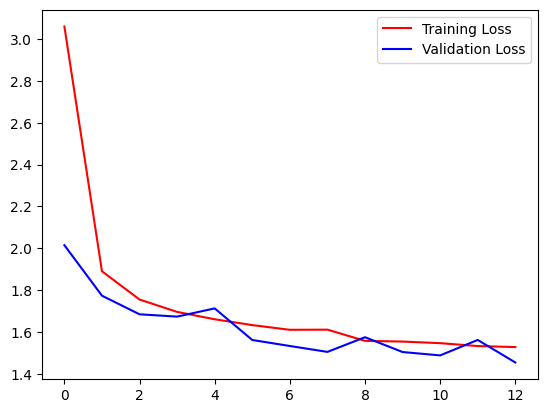

In [12]:
# 📉 Plot training vs. validation loss to visualize model performance over epochs
plt.plot(history.history["loss"], 'r', label="Training Loss")
plt.plot(history.history["val_loss"], 'b', label="Validation Loss")
plt.legend()


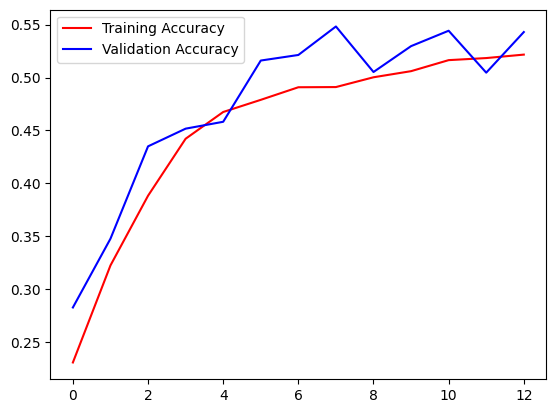

In [13]:
# Plot training vs. validation accuracy to evaluate model performance over epochs
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")
plt.legend()

In [14]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5419 - loss: 1.4682
Test Acc: 0.5497353076934814


In [15]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


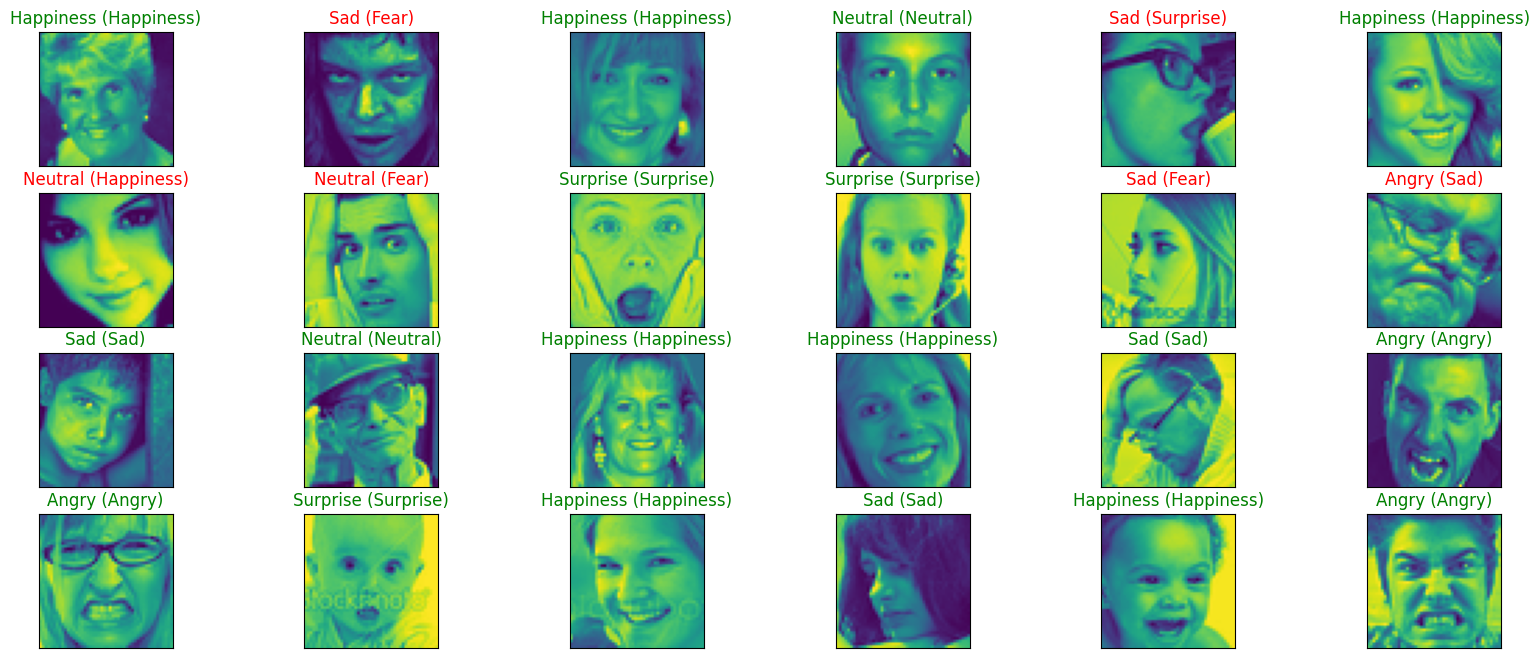

In [16]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))